<a href="https://colab.research.google.com/github/jellybelly0215/Test/blob/master/DL_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('user uploaded file"{name}"with length {length} bytes'.format(name=fn,length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
user uploaded file"kaggle.json"with length 66 bytes


In [4]:
!mkdir -p ~/.kaggle/

In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/llm-detect-ai-generated-text                  2024-01-22 23:59:00  Featured          $110,000       2099           False  
https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding                2023-12-07 23:59:00  Research          $100,000        747           False  
https://www.kaggle.com/competitions/optiver-trading-at-the-close                  2023-12-20 23:59:00  Featured          $100,000       3905           False  
https://www.kaggle.com/competitions/nfl-big-data-bowl-2024                        2024-01-08 23:59:00  Analytics         $100,000          0           False  
https://www.kaggle.com/competitions/blood-vess

In [8]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 609M/612M [00:08<00:00, 142MB/s]
100% 612M/612M [00:08<00:00, 76.1MB/s]


In [9]:
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [10]:
import pandas as pd
import numpy as np

import os
import pathlib

import cv2
from PIL import Image
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

np.random.seed(42)

%matplotlib inline

In [11]:
data_dir = pathlib.Path('/content/Meta')
train_path = pathlib.Path('/content/Train')
test_path = pathlib.Path('/content/Test')

IMG_HEGHT = 30
IMG_WIDTH = 30
channels = 3

NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

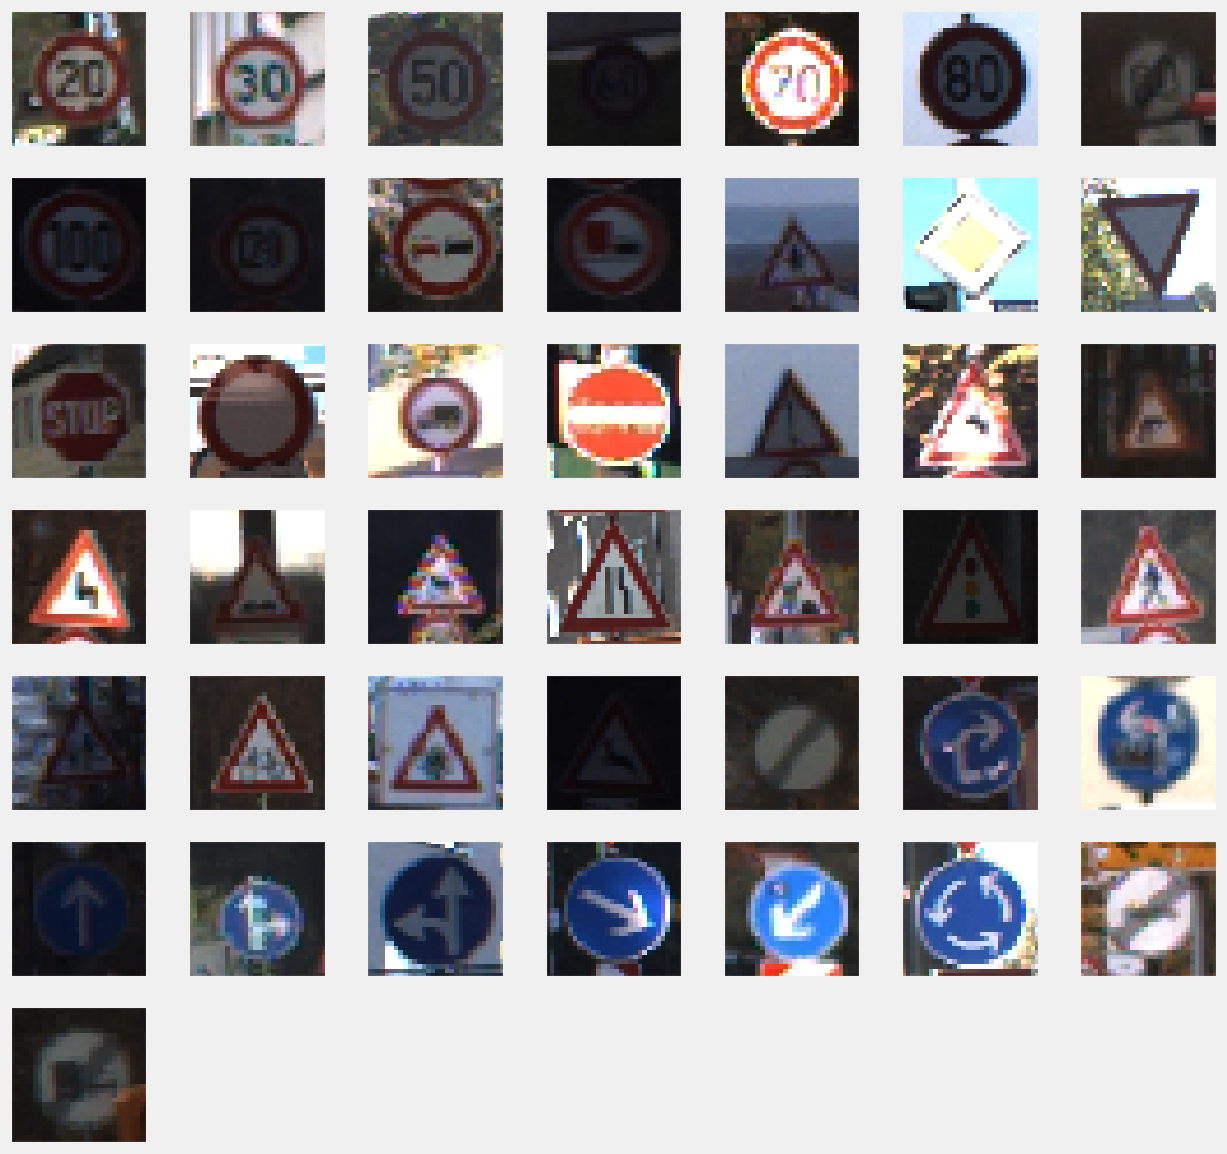

In [12]:
img_dir = pathlib.Path('/content/train')
plt.figure(figsize=(14,14))
index = 0
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(30, 30))
    plt.imshow(img)
plt.show()

In [13]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

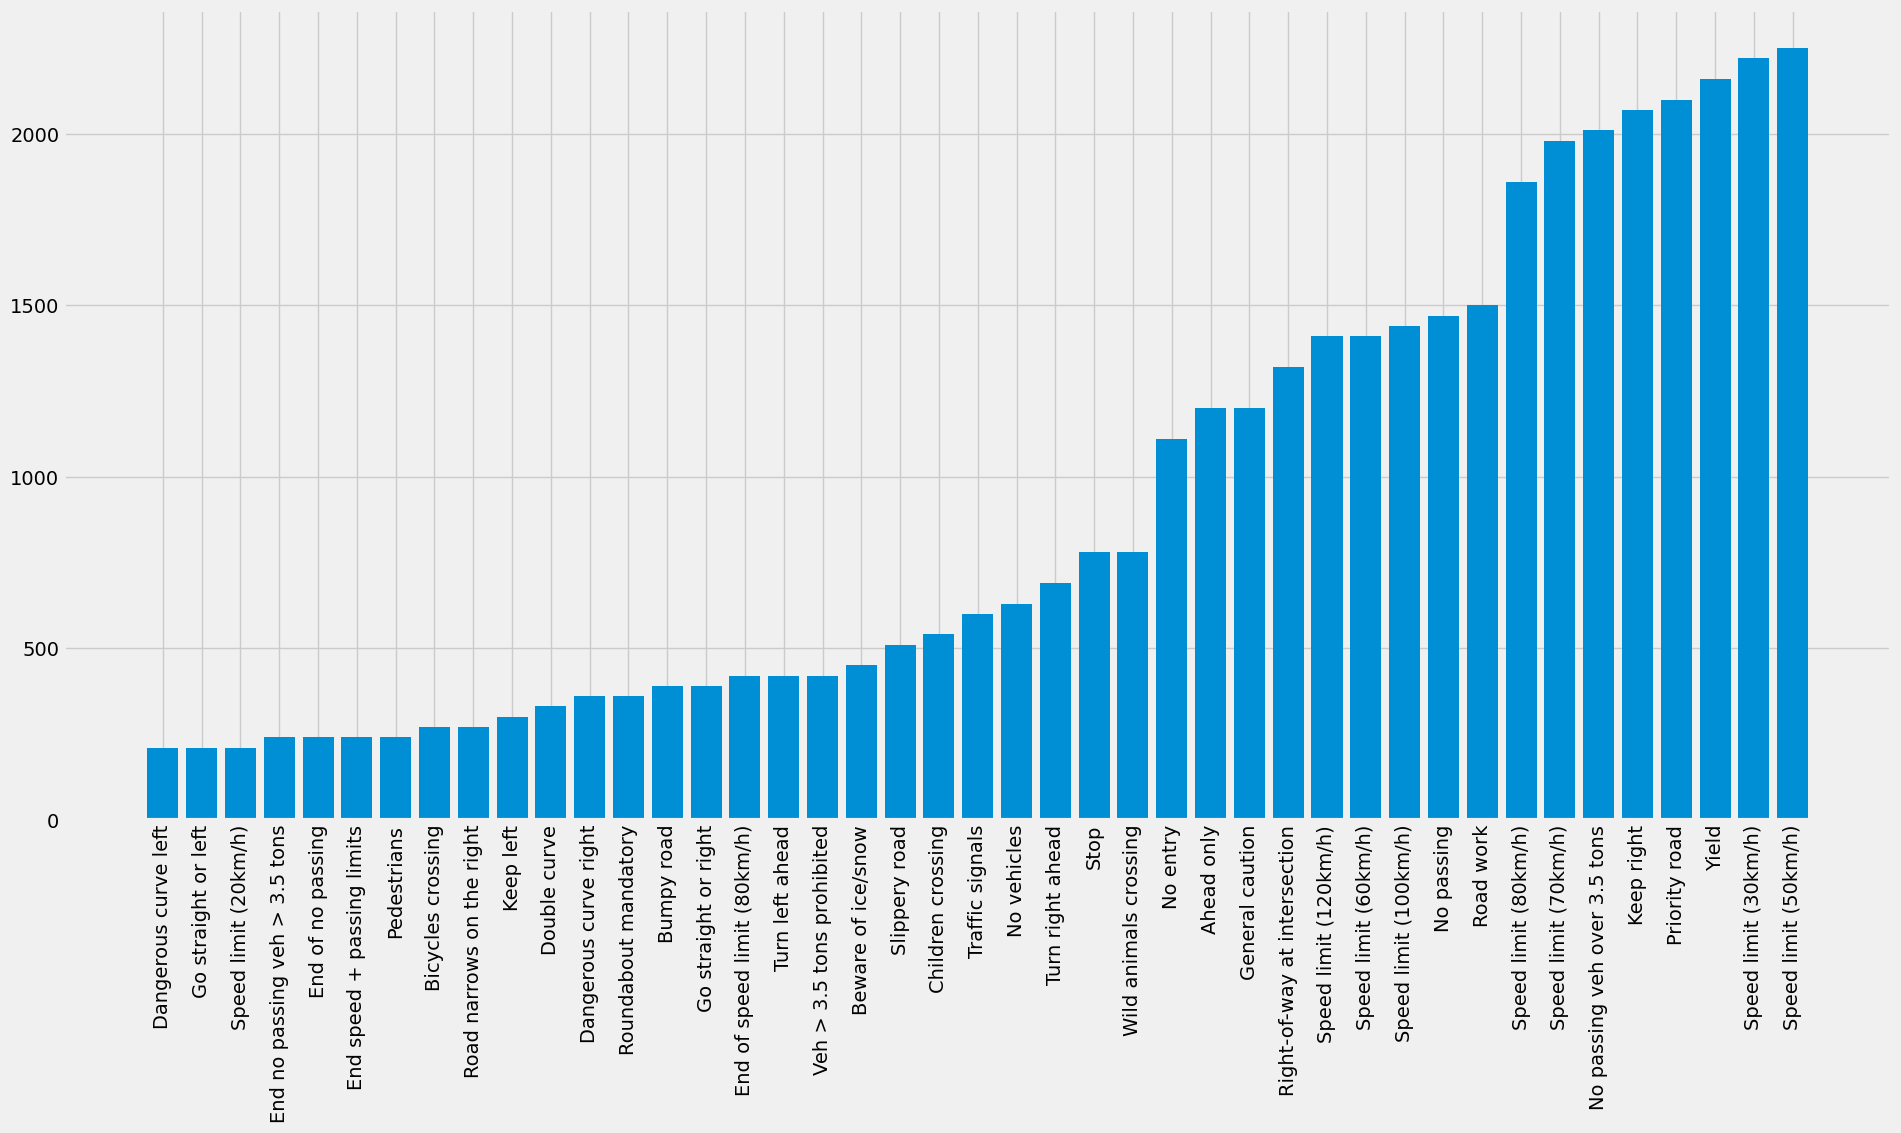

In [14]:
folders = os.listdir('/content/Train')

train_num = []
class_num = []

for folder in folders:
  train_files = os.listdir(str(train_path) + '/'+ folder)
  train_num.append(len(train_files))
  class_num.append(classes[int(folder)])

zipped_lists =  zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples =  zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in tuples]

plt.figure(figsize = (21, 10))
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [15]:
def load_data(data_dir):
    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=(30, 30))
            image = img_to_array(img)
            images.append(image)
            labels.append(category)

    return images, labels

images, labels = load_data(train_path)

labels = to_categorical(labels)

x_train, x_test, y_train, y_test = train_test_split(np.array(images), labels, test_size=0.4)

In [16]:
model = Sequential()

IMG_HEIGHT = 30
IMG_WIDTH = 30

model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [17]:
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

EPOCHS = 40
history = model.fit(x_train,
                    y_train,
                    validation_data = (x_test, y_test),
                    epochs=EPOCHS,
                    steps_per_epoch=60
                   )

Epoch 1/40
60/60 [==============================] - 18s 46ms/step - loss: 5.7025 - accuracy: 0.0369 - val_loss: 3.6757 - val_accuracy: 0.0611
Epoch 2/40
60/60 [==============================] - 3s 50ms/step - loss: 3.4320 - accuracy: 0.1294 - val_loss: 2.9416 - val_accuracy: 0.2908
Epoch 3/40
60/60 [==============================] - 3s 55ms/step - loss: 2.6001 - accuracy: 0.3132 - val_loss: 2.1439 - val_accuracy: 0.4325
Epoch 4/40
60/60 [==============================] - 3s 57ms/step - loss: 1.9535 - accuracy: 0.4374 - val_loss: 1.5540 - val_accuracy: 0.5691
Epoch 5/40
60/60 [==============================] - 4s 65ms/step - loss: 1.5118 - accuracy: 0.5481 - val_loss: 1.1256 - val_accuracy: 0.6973
Epoch 6/40
60/60 [==============================] - 4s 63ms/step - loss: 1.1666 - accuracy: 0.6538 - val_loss: 0.8170 - val_accuracy: 0.7821
Epoch 7/40
60/60 [==============================] - 2s 37ms/step - loss: 0.8895 - accuracy: 0.7392 - val_loss: 0.6082 - val_accuracy: 0.8410
Epoch 8/40
6

In [19]:
loss, accuracy = model.evaluate(x_test, y_test)

print('Test Set accuracy: ', accuracy * 100)

491/491 [==============================] - 2s 3ms/step - loss: 0.0689 - accuracy: 0.9844
Test Set accuracy:  98.44427704811096


In [20]:
train_loss, train_accuracy = model.evaluate(x_train, y_train)

print('Training Set accuracy: ', train_accuracy * 100)

736/736 [==============================] - 3s 4ms/step - loss: 0.0167 - accuracy: 0.9966
Training Set accuracy:  99.66418743133545


In [23]:
def learning_curve(history, epoch):
  plt.figure(figsize=(10,5))
  # 정확도 차트
  epoch_range = np.arange(1, epoch + 1)

  plt.subplot(1, 2, 1)

  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel("Accurach")
  plt.legend( ['Train', 'Val']  )
  # plt.show()

  # loss 차트
  plt.subplot(1, 2, 2)

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel("Loss")
  plt.legend( ['Train', 'Val']  )

  plt.show()

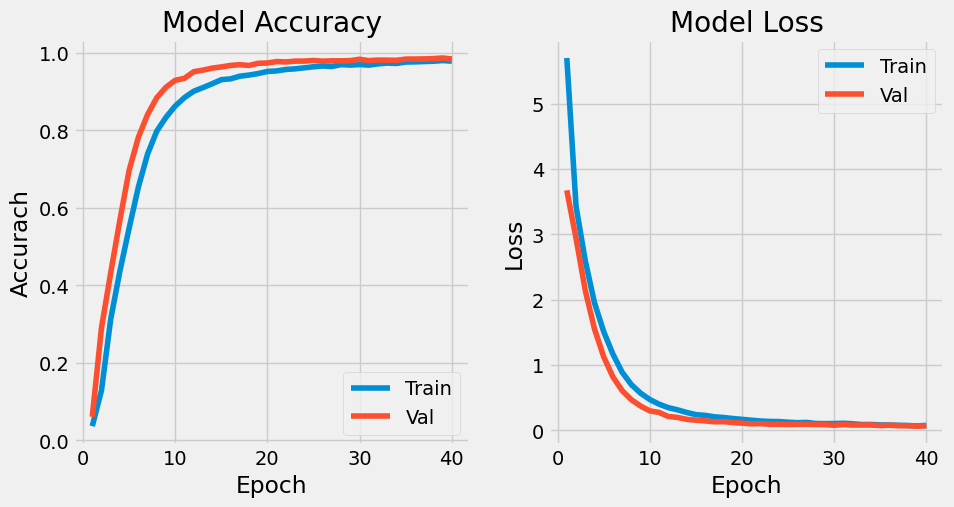

In [24]:
learning_curve(history, 40)

In [25]:
Y_test = pd.read_csv('/content/Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

a =  pathlib.Path('/content/')

output = list()
for img in test_images:
    image = load_img(os.path.join(a, img), target_size=(30, 30))
    output.append(np.array(image))

X_test=np.array(output)
y_prob = model.predict(X_test)
pred = y_prob.argmax(axis=-1)

print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 [==============================] - 1s 3ms/step
Test Data accuracy:  93.29374505146477


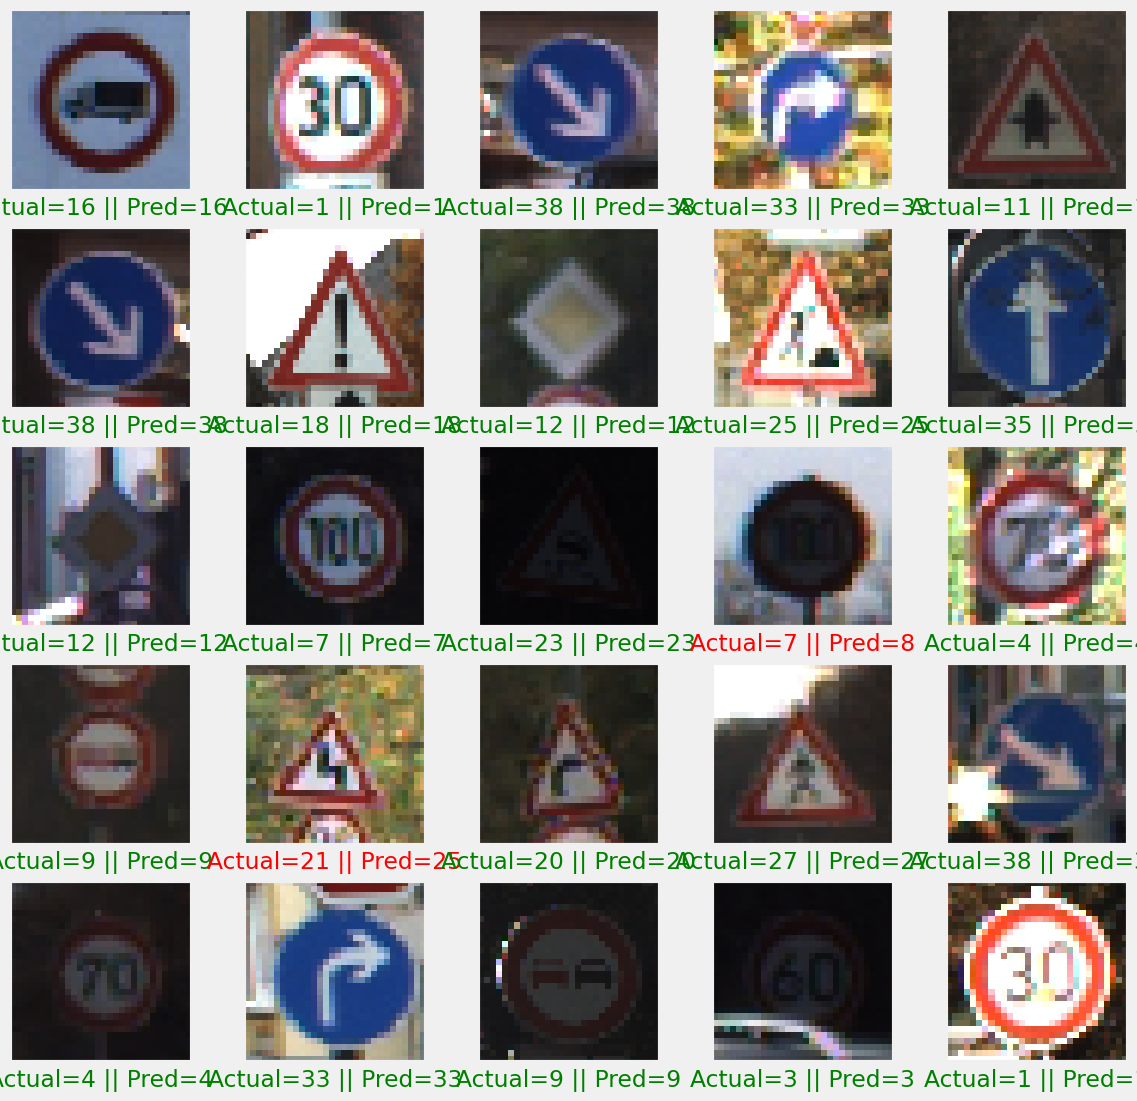

In [26]:
plt.figure(figsize = (13, 13))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()